In [ ]:
'''
lateral threshold 0.1%
                 Feature        p-value
0                    ATR  7.447206e-240
1                 Volume   8.148102e-67
2          BB Upper Band   2.166749e-44
3                    ADX   2.894173e-41
4  Simple Moving Average   1.284026e-40
5               BB Basis   2.415954e-40
6          BB Lower Band   2.689015e-36
7                    RSI   5.387240e-28
8              Histogram   1.206250e-08
9              MACD Line   4.415389e-05
Fitting 3 folds for each of 32 candidates, totalling 96 fits
...
    accuracy                           0.42      8453
   macro avg       0.43      0.41      0.41      8453
weighted avg       0.43      0.42      0.42      8453

lateral threshold 0.5%
P-Values das Features:
                 Feature        p-value
0                    ATR   0.000000e+00
1                 Volume  7.886488e-124
3                    ADX   1.899459e-79
2          BB Upper Band   9.782987e-26
9              MACD Line   3.730351e-24
4  Simple Moving Average   7.940985e-22
5               BB Basis   1.169944e-20
6          BB Lower Band   5.374425e-16
7                    RSI   1.930591e-11
8              Histogram   7.231106e-04

              precision    recall  f1-score   support

   0 (Baixa)       0.34      0.03      0.05      1029
 1 (Lateral)       0.76      0.99      0.86      6269
    2 (Alta)       0.49      0.06      0.11      1155

    accuracy                           0.75      8453
   macro avg       0.53      0.36      0.34      8453
weighted avg       0.67      0.75      0.66      8453

lateral threshold 1%
P-Values das Features:
                 Feature        p-value
0                    ATR   0.000000e+00
1                 Volume  7.886488e-124
3                    ADX   1.899459e-79
2          BB Upper Band   9.782987e-26
9              MACD Line   3.730351e-24
4  Simple Moving Average   7.940985e-22
5               BB Basis   1.169944e-20
6          BB Lower Band   5.374425e-16
7                    RSI   1.930591e-11
8              Histogram   7.231106e-04
'''

Distribuição de classes por lateral_threshold:
Lateral Threshold: 0.001
trend
2    0.390039
0    0.373193
1    0.236768
Name: proportion, dtype: float64
Lateral Threshold: 0.002
trend
1    0.431184
2    0.292772
0    0.276044
Name: proportion, dtype: float64
Lateral Threshold: 0.003
trend
1    0.572034
2    0.220655
0    0.207311
Name: proportion, dtype: float64
Lateral Threshold: 0.004
trend
1    0.670791
2    0.171182
0    0.158027
Name: proportion, dtype: float64
Lateral Threshold: 0.005
trend
1    0.744943
2    0.131929
0    0.123128
Name: proportion, dtype: float64
Lateral Threshold: 0.006
trend
1    0.796948
2    0.104413
0    0.098640
Name: proportion, dtype: float64
Lateral Threshold: 0.007
trend
1    0.837170
2    0.083166
0    0.079664
Name: proportion, dtype: float64
Lateral Threshold: 0.008
trend
1    0.867597
2    0.067668
0    0.064734
Name: proportion, dtype: float64
Lateral Threshold: 0.009
trend
1    0.891447
2    0.055578
0    0.052975
Name: proportion, dtype: float64

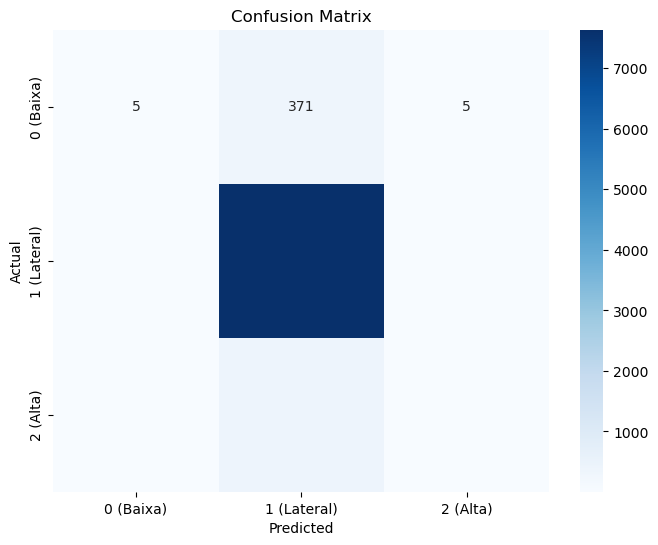

In [28]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE

# Caminho base para a pasta 'data' relativa ao diretório atual
base_path = os.path.join(os.getcwd(), 'data')

# Features selecionadas com base nos p-values
selected_features = ['ATR', 'Volume', 'BB Upper Band', 'ADX', 
                     'Simple Moving Average', 'BB Basis', 
                     'BB Lower Band', 'RSI', 'Histogram', 'MACD Line']

# Função para criar a coluna de tendência
def label_trend(df, lateral_threshold=0.001):
    """
    Cria uma coluna de tendência no DataFrame:
    - 0 para Lateral
    - 1 para Alta
    - 2 para Baixa
    """
    df = df.copy()
    df['pct_change'] = df['close'].pct_change().shift(-1)
    df['trend'] = 0  # Padrão: Lateral
    df.loc[df['pct_change'] > lateral_threshold, 'trend'] = 1  # Alta
    df.loc[df['pct_change'] < -lateral_threshold, 'trend'] = -1  # Baixa
    df.drop(columns=['pct_change'], inplace=True)  # Remover coluna auxiliar
    return df

# Função para processar os dados e preparar X e y
def process_data(df, lateral_threshold):
    """
    Recalcula o 'trend' e prepara X e y.
    """
    df = label_trend(df, lateral_threshold=lateral_threshold)
    y = df['trend'].map({-1: 0, 0: 1, 1: 2})  # Ajustar para 0, 1, 2
    X = df[selected_features]
    return X.dropna(), y.loc[X.dropna().index]

# Carregar o dataset processado
dataset_path = os.path.join(base_path, 'bybit/1h/btcusdt.csv')
df = pd.read_csv(dataset_path)

# Analisar a distribuição das classes para diferentes valores de lateral_threshold
print("Distribuição de classes por lateral_threshold:")
for threshold in np.arange(0.001, 0.011, 0.001):
    _, y_temp = process_data(df, threshold)
    print(f"Lateral Threshold: {threshold:.3f}")
    print(y_temp.value_counts(normalize=True))

# Configuração do GridSearch
param_grid = {
    'lateral_threshold': np.arange(0.001, 0.011, 0.001),  # Valores de 0.001 a 0.01
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Função para pipeline de treinamento
def train_with_gridsearch(df, param_grid):
    best_params = None
    best_score = 0
    results = []
    
    for lateral_threshold in param_grid['lateral_threshold']:
        # Processar os dados para o threshold atual
        X, y = process_data(df, lateral_threshold)
        
        # Remover valores ausentes
        X = X.dropna()
        y = y.loc[X.index]
        
        # Dividir os dados em treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Balancear as classes usando SMOTE
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
        # Normalizar os dados
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Treinar o modelo com GridSearch
        grid = GridSearchCV(
            estimator=XGBClassifier(eval_metric='mlogloss', verbosity=0),
            param_grid={k: v for k, v in param_grid.items() if k != 'lateral_threshold'},
            scoring='f1_macro',  # Usar F1-Score Macro para equilibrar todas as classes
            cv=3,
            verbose=2
        )
        grid.fit(X_train, y_train)
        
        # Avaliar no conjunto de teste
        y_pred = grid.best_estimator_.predict(X_test)
        score = grid.best_estimator_.score(X_test, y_test)
        results.append((lateral_threshold, grid.best_params_, score))
        
        # Atualizar o melhor modelo
        if score > best_score:
            best_score = score
            best_params = (lateral_threshold, grid.best_params_)
    
    return best_params, results

# Executar o treinamento
best_params, results = train_with_gridsearch(df, param_grid)

# Exibir os resultados
print("Melhores parâmetros:")
print(f"Lateral Threshold: {best_params[0]}")
print(f"XGBoost Params: {best_params[1]}")

# Avaliar e plotar a matriz de confusão para o melhor modelo
best_lateral_threshold = best_params[0]
X, y = process_data(df, best_lateral_threshold)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

best_model = XGBClassifier(**best_params[1], eval_metric='mlogloss', verbosity=0)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Relatório de classificação
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["0 (Baixa)", "1 (Lateral)", "2 (Alta)"]))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=["0 (Baixa)", "1 (Lateral)", "2 (Alta)"], 
    yticklabels=["0 (Baixa)", "1 (Lateral)", "2 (Alta)"]
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


📊 Distribuição de classes por lateral_threshold:
Lateral Threshold: 0.001
Threshold: trend_threshold
2    0.389868
0    0.373202
1    0.236929
Name: proportion, dtype: float64
Médias Móveis: trend_ma
2    0.441091
0    0.370730
1    0.188178
Name: proportion, dtype: float64
ADX: trend_adx
1    0.478025
0    0.274005
2    0.247970
Name: proportion, dtype: float64
--------------------------------------------------
Lateral Threshold: 0.002
Threshold: trend_threshold
1    0.431087
2    0.292719
0    0.276194
Name: proportion, dtype: float64
Médias Móveis: trend_ma
2    0.441091
0    0.370730
1    0.188178
Name: proportion, dtype: float64
ADX: trend_adx
1    0.478025
0    0.274005
2    0.247970
Name: proportion, dtype: float64
--------------------------------------------------
Lateral Threshold: 0.003
Threshold: trend_threshold
1    0.572138
2    0.220546
0    0.207316
Name: proportion, dtype: float64
Médias Móveis: trend_ma
2    0.441091
0    0.370730
1    0.188178
Name: proportion, dtype:

100%|██████████| 8/8 [02:02<00:00, 15.26s/it]



✅ GridSearch concluído em 122.11 segundos
🔄 Treinando 8 combinações de hiperparâmetros...


100%|██████████| 8/8 [01:49<00:00, 13.69s/it]



✅ GridSearch concluído em 109.54 segundos
🔄 Treinando 8 combinações de hiperparâmetros...


100%|██████████| 8/8 [01:37<00:00, 12.15s/it]


✅ GridSearch concluído em 97.19 segundos

================= Threshold =================
Melhores Parâmetros: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosit

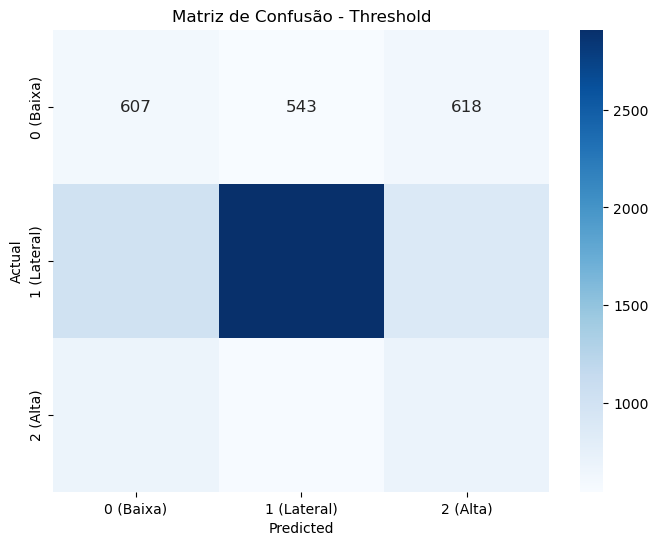


================= Médias Móveis =================
Melhores Parâmetros: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0}
Acurácia: 0.8907

📌 Classificat

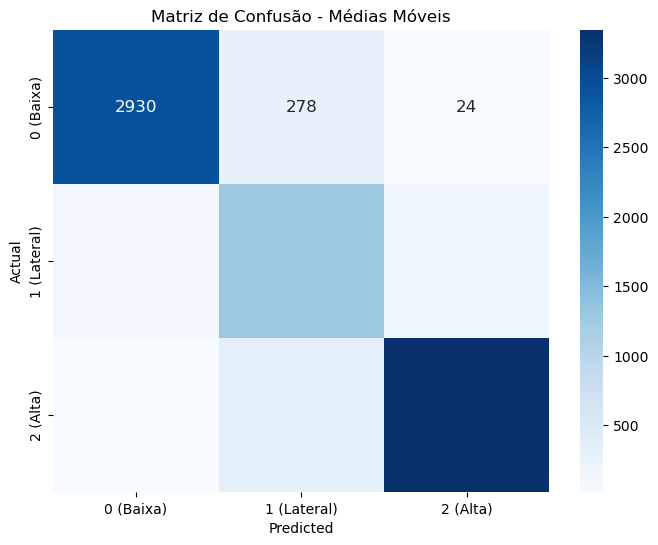


================= ADX =================
Melhores Parâmetros: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0}
Acurácia: 0.9793

📌 Classification Report

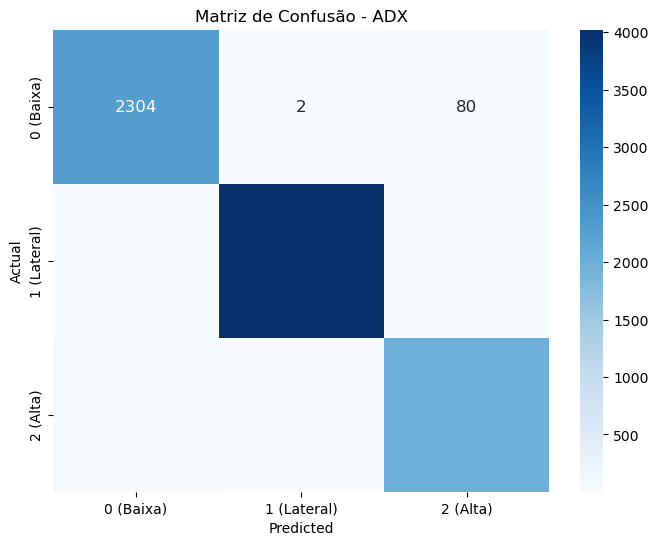

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Caminho base para a pasta 'data'
base_path = os.path.join(os.getcwd(), 'data')

# Nome correto do arquivo
dataset_path = os.path.join(base_path, 'bybit/1h/btcusdt.csv')

# Features selecionadas com base nos p-values
selected_features = ['ATR', 'Volume', 'BB Upper Band', 'ADX', 
                     'Simple Moving Average', 'BB Basis', 
                     'BB Lower Band', 'RSI', 'Histogram', 'MACD Line']

# Parâmetros de Médias Móveis e ADX por timeframe
ma_settings = {
    '1D': {'ma_short': 50, 'ma_long': 200, 'adx_limit': 20, 'adx_period': 14},
    '4H': {'ma_short': 40, 'ma_long': 100, 'adx_limit': 22, 'adx_period': 12},
    '1H': {'ma_short': 20, 'ma_long': 50, 'adx_limit': 25, 'adx_period': 10}
}

# Seleção do timeframe
timeframe = '1H'
ma_short = ma_settings[timeframe]['ma_short']
ma_long = ma_settings[timeframe]['ma_long']
adx_limit = ma_settings[timeframe]['adx_limit']
adx_period = ma_settings[timeframe]['adx_period']

# Função para criar a tendência com lateral_threshold
def label_trend_threshold(df, lateral_threshold=0.001):
    df = df.copy()
    df['pct_change'] = df['close'].pct_change().shift(-1)
    df['trend_threshold'] = 1  
    df.loc[df['pct_change'] > lateral_threshold, 'trend_threshold'] = 2  
    df.loc[df['pct_change'] < -lateral_threshold, 'trend_threshold'] = 0  
    df.drop(columns=['pct_change'], inplace=True)
    return df

# Função para criar a tendência com Médias Móveis
def label_trend_ma(df):
    df = df.copy()
    df['ma_short'] = df['close'].rolling(ma_short).mean()
    df['ma_long'] = df['close'].rolling(ma_long).mean()
    df['trend_ma'] = 1  
    df.loc[(df['close'] > df['ma_long']) & (df['ma_short'] > df['ma_long']), 'trend_ma'] = 2  
    df.loc[(df['close'] < df['ma_long']) & (df['ma_short'] < df['ma_long']), 'trend_ma'] = 0  
    return df.drop(columns=['ma_short', 'ma_long'])

# Função para criar a tendência com ADX
def label_trend_adx(df):
    """
    Define a tendência de mercado baseada no ADX, +DI e -DI:
    - 0 para Baixa (tendência de queda forte)
    - 1 para Lateral (mercado sem força direcional)
    - 2 para Alta (tendência de alta forte)
    """
    df = df.copy()
    df['trend_adx'] = 1  # Padrão: Lateral

    # Classifica como Alta se ADX for alto e +DI > -DI
    df.loc[(df['ADX'] > adx_limit) & (df['DI+'] > df['DI-']), 'trend_adx'] = 2  

    # Classifica como Baixa se ADX for alto e -DI > +DI
    df.loc[(df['ADX'] > adx_limit) & (df['DI-'] > df['DI+']), 'trend_adx'] = 0  

    return df


# Função para processar os dados com as 3 abordagens
def process_data(df, lateral_threshold):
    df = label_trend_threshold(df, lateral_threshold)
    df = label_trend_ma(df)
    df = label_trend_adx(df)
    
    y_threshold = df['trend_threshold']
    y_ma = df['trend_ma']
    y_adx = df['trend_adx']
    
    X = df[selected_features]
    return X.dropna(), y_threshold.loc[X.dropna().index], y_ma.loc[X.dropna().index], y_adx.loc[X.dropna().index]

# Carregar o dataset
df = pd.read_csv(dataset_path)

# Testar diferentes valores de lateral_threshold
print("📊 Distribuição de classes por lateral_threshold:")
for threshold in np.arange(0.001, 0.006, 0.001):
    _, y_thresh, y_ma, y_adx = process_data(df, threshold)
    print(f"Lateral Threshold: {threshold:.3f}")
    print("Threshold:", y_thresh.value_counts(normalize=True))
    print("Médias Móveis:", y_ma.value_counts(normalize=True))
    print("ADX:", y_adx.value_counts(normalize=True))
    print("-" * 50)

# Função de treinamento e GridSearch com Barra de Progresso
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
    
    grid = GridSearchCV(
        estimator=XGBClassifier(eval_metric='mlogloss', verbosity=0),
        param_grid=param_grid,
        scoring='f1_macro',
        cv=3
    )
    
    # Criar barra de progresso com tqdm
    print(f"🔄 Treinando {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate'])} combinações de hiperparâmetros...")
    start_time = time.time()
    
    for _ in tqdm(range(len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']))):
        grid.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    print(f"\n✅ GridSearch concluído em {elapsed_time:.2f} segundos")
    
    return grid.best_estimator_, X_test, y_test

# Melhor modelo para cada abordagem
X, y_threshold, y_ma, y_adx = process_data(df, 0.003)
best_model_threshold, X_test_t, y_test_t = train_model(X, y_threshold)
best_model_ma, X_test_m, y_test_m = train_model(X, y_ma)
best_model_adx, X_test_a, y_test_a = train_model(X, y_adx)

# Função para exibir matriz de confusão
def plot_confusion_matrix(y_test, y_pred, title):
    labels = ["0 (Baixa)", "1 (Lateral)", "2 (Alta)"]
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Exibir melhores resultados
def print_model_performance(model, X_test, y_test, method_name):
    y_pred = model.predict(X_test)
    
    print(f"\n================= {method_name} =================")
    print(f"Melhores Parâmetros: {model.get_params()}")
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}\n")
    
    print("📌 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["0 (Baixa)", "1 (Lateral)", "2 (Alta)"]))
    
    plot_confusion_matrix(y_test, y_pred, f"Matriz de Confusão - {method_name}")

print_model_performance(best_model_threshold, X_test_t, y_test_t, "Threshold")
print_model_performance(best_model_ma, X_test_m, y_test_m, "Médias Móveis")
print_model_performance(best_model_adx, X_test_a, y_test_a, "ADX")
